## Deep Learning with Metadata and Poster PCAs

In [1]:
from keras import regularizers
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split

import h5py as h5py
import keras.backend as K
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 7})
%config InlineBackend.figure_format = 'png2x'

In [3]:
def score_genres(y_true, y_pred, threshold=0.5):
    predicted = np.array([[int(p > threshold) for p in row] for row in y_pred])
    means = []
    
    for pred, actual in zip(predicted, y_true):
        label_ind = np.unique(np.concatenate((np.nonzero(pred), np.nonzero(actual)), axis=1))
        means.append(np.mean(pred[label_ind] == actual[label_ind]))
        
    return np.mean(means)

def score_plot_genres(model, x_test, y_true, thresholds=np.arange(0, 1, 0.025)):
    predictions = model.predict(x_test)
    scores = [score_genres(y_true, predictions, t) for t in thresholds]

    plt.figure(figsize=(6, 3.5), dpi=125)
    plt.plot(thresholds, scores, color='#2196F3', linewidth=1)
    plt.title('Score vs Probability Threshold - Max {:.3f} with t = {:.3f}'
              .format(np.max(scores), thresholds[np.argmax(scores)]))
    plt.xlabel('Threshold'); plt.ylabel('Score')
    plt.show()
    
def history_plot(history):
    plt.figure(figsize=(6, 3.5), dpi=125)
    plt.plot(history.history['recall'], color='#2196F3', linewidth=1)
    plt.title('Recall Accuracy vs Epoch')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.show()

# Multi-label scoring function from an unreleased version of Keras
# https://github.com/fchollet/keras/blob/c2e36f369b411ad1d0a40ac096fe35f73b9dffd3/keras/metrics.py
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Creates a bar plot with recall accuracy, false negative rate, and false positive rate per genre
def plot_genre_accuracy(model, x_test, y_test, threshold=0.5):
    predicted = np.array([[int(p > threshold) for p in row] for row in model.predict(x_test)])
    correct_recall, false_neg, false_pos, genre_inds = [], [], [], np.arange(19)

    for genre in genre_inds:
        false_n_ind = np.nonzero(y_test[:, genre])
        false_p_ind = np.nonzero(predicted[:, genre])
        recall_slice = predicted[false_n_ind, genre] == y_test[false_n_ind, genre]
        false_n_slice = predicted[false_n_ind, genre] != y_test[false_n_ind, genre]
        false_p_slice = predicted[false_p_ind, genre] != y_test[false_p_ind, genre]
        correct_recall.append(np.mean(recall_slice) * 100 if recall_slice.any() else 0)
        false_neg.append(np.mean(false_n_slice) * 100 if false_n_slice.any() else 0)
        false_pos.append(np.mean(false_p_slice) * 100 if false_p_slice.any() else 0)

    plt.figure(figsize=(8, 4.5), dpi=125)

    plt.bar(genre_inds - 0.2, correct_recall, width=0.2, color='#81C784', align='center', label='Correct Recall')
    plt.bar(genre_inds, false_pos, width=0.2, color='#7E57C2', align='center', label='False Positive')
    plt.bar(genre_inds + 0.2, false_neg, width=0.2, color='#29B6F6', align='center', label='False Negative')

    plt.xticks(genre_inds, genre_names, rotation=90)

    # Make legend box slighly less ugly
    legend = plt.legend()
    legend.get_frame().set_linewidth(0.5)

    plt.xlabel('Genre'); plt.ylabel('Percentage'); plt.title('Accuracy by Genre')
    plt.tight_layout(); plt.show()
    
def split_df(x, y, train_size=0.8, train_indices=np.array([])):
    # Use custom indices if they exist
    if train_indices.any():
        return (x.loc[train_indices], x.drop(train_indices),
                np.array(y.loc[train_indices]), np.array(y.drop(train_indices)))
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size)
    return (x_train, x_test, np.array(y_train), np.array(y_test))

In [4]:
metadata = pd.read_pickle('./datasets/metadata.pkl')
pca_vects = pd.read_csv('./datasets/pca_vects.csv')
genres = pd.read_pickle('./datasets/genres.pkl')
genre_names = np.load('./datasets/genre_names.npy')

# Combine metadata and poster PCA components
pca_vects.drop(['id'], axis=1, inplace=True)
pca_vects.index = metadata.index
both_df = pd.concat([metadata, pca_vects], axis=1)

In [5]:
meta_x_train, meta_x_test, meta_y_train, meta_y_test = split_df(metadata, genres)

# Use same indices for the other datasets to make the comparisons fair
pca_x_train, pca_x_test, pca_y_train, pca_y_test = split_df(pca_vects, genres, train_indices=meta_x_train.index)
both_x_train, both_x_test, both_y_train, both_y_test = split_df(both_df, genres, train_indices=meta_x_train.index)

In [6]:
# Creates and fit a sequential model using instructions from
# https://keras.io/getting-started/sequential-model-guide/
def fit_seq_model(x_train, y_train, x_test, y_test):
    model = Sequential()
    model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(19, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[recall])
    
    history = model.fit(x_train, y_train, epochs=20, batch_size=128,
                        validation_data=(x_test, y_test), verbose=0)
    
    return (model, history)

### Metadata

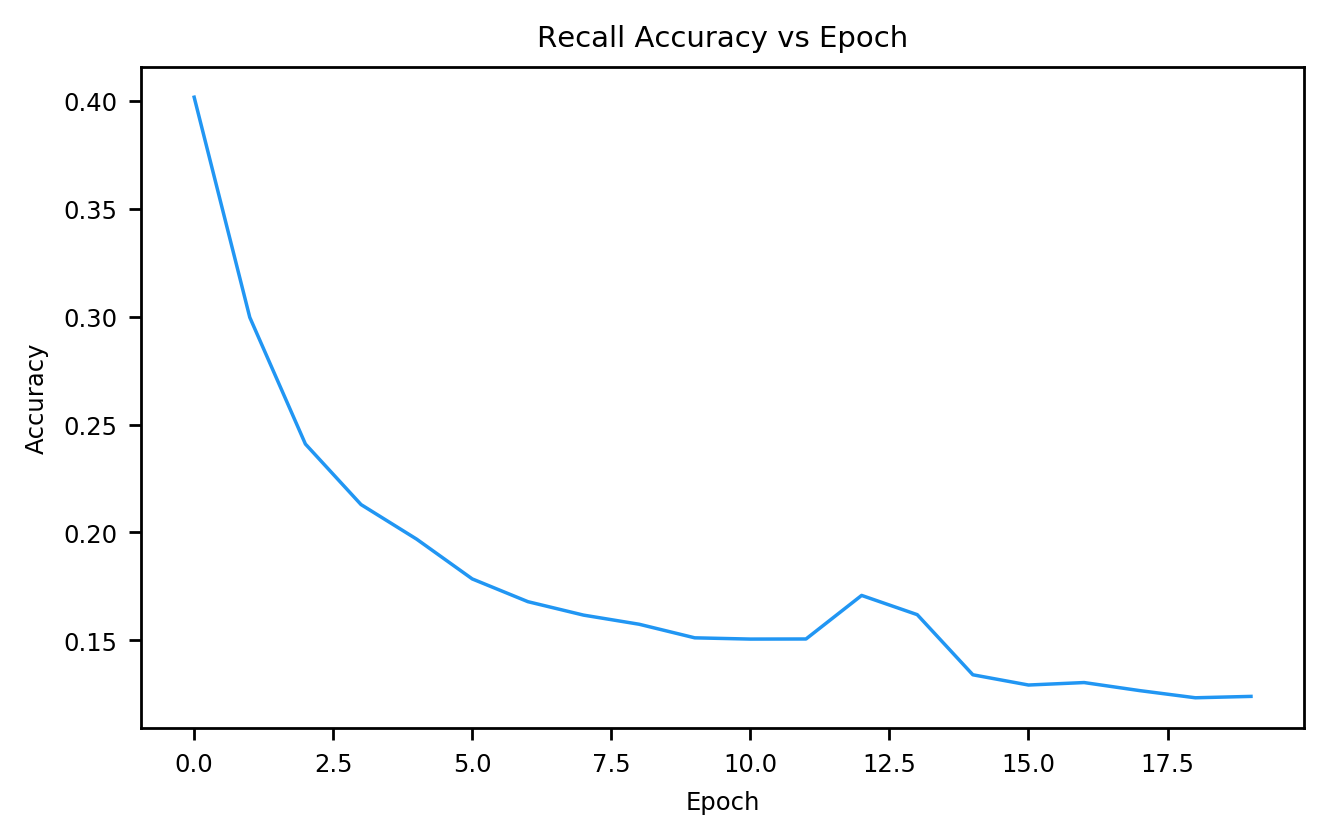

In [7]:
model, history = fit_seq_model(meta_x_train.as_matrix(), meta_y_train, meta_x_test.as_matrix(), meta_y_test)
history_plot(history)

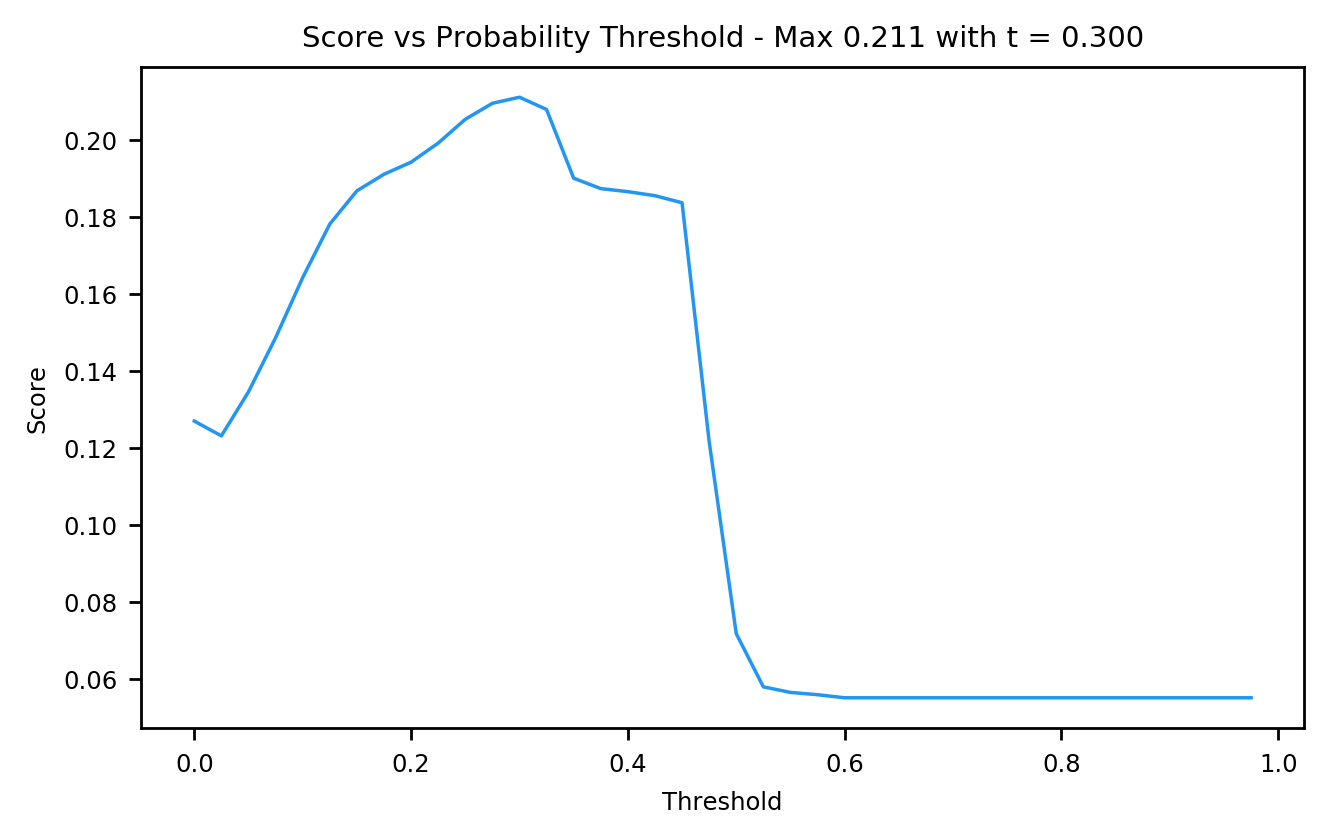

In [8]:
score_plot_genres(model, meta_x_test.as_matrix(), meta_y_test)

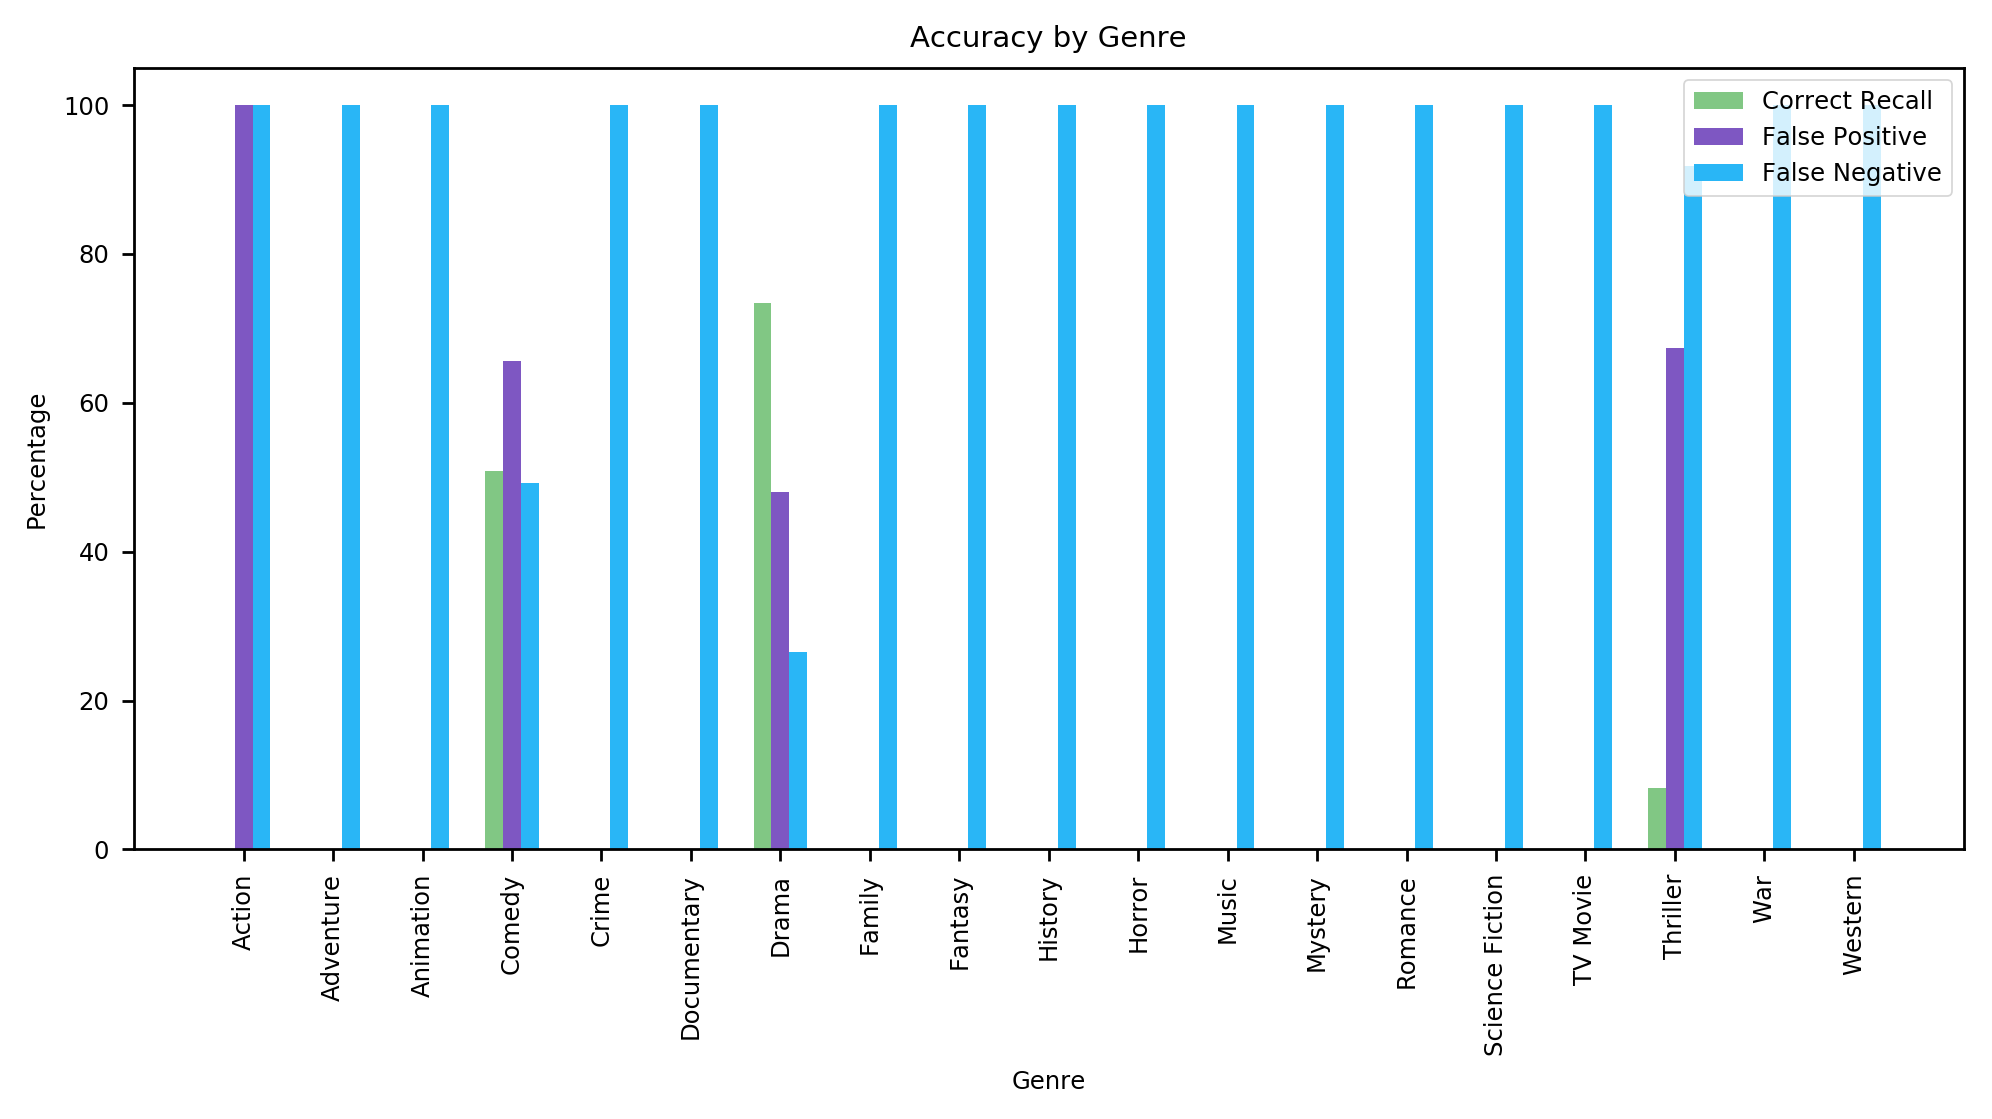

In [9]:
plot_genre_accuracy(model, meta_x_test.as_matrix(), meta_y_test, 0.3)

### Poster PCAs

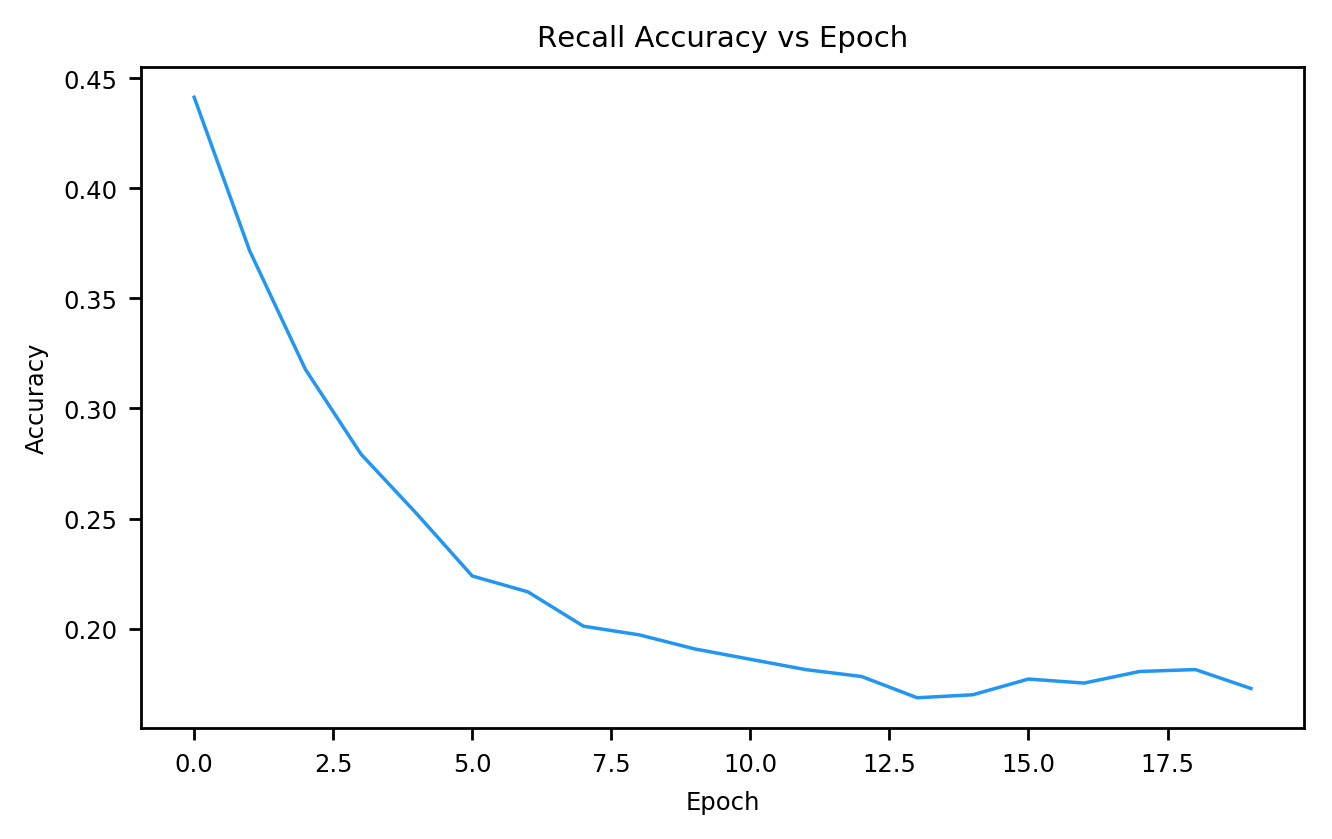

In [10]:
model, history = fit_seq_model(pca_x_train.as_matrix(), pca_y_train, pca_x_test.as_matrix(), pca_y_test)
history_plot(history)

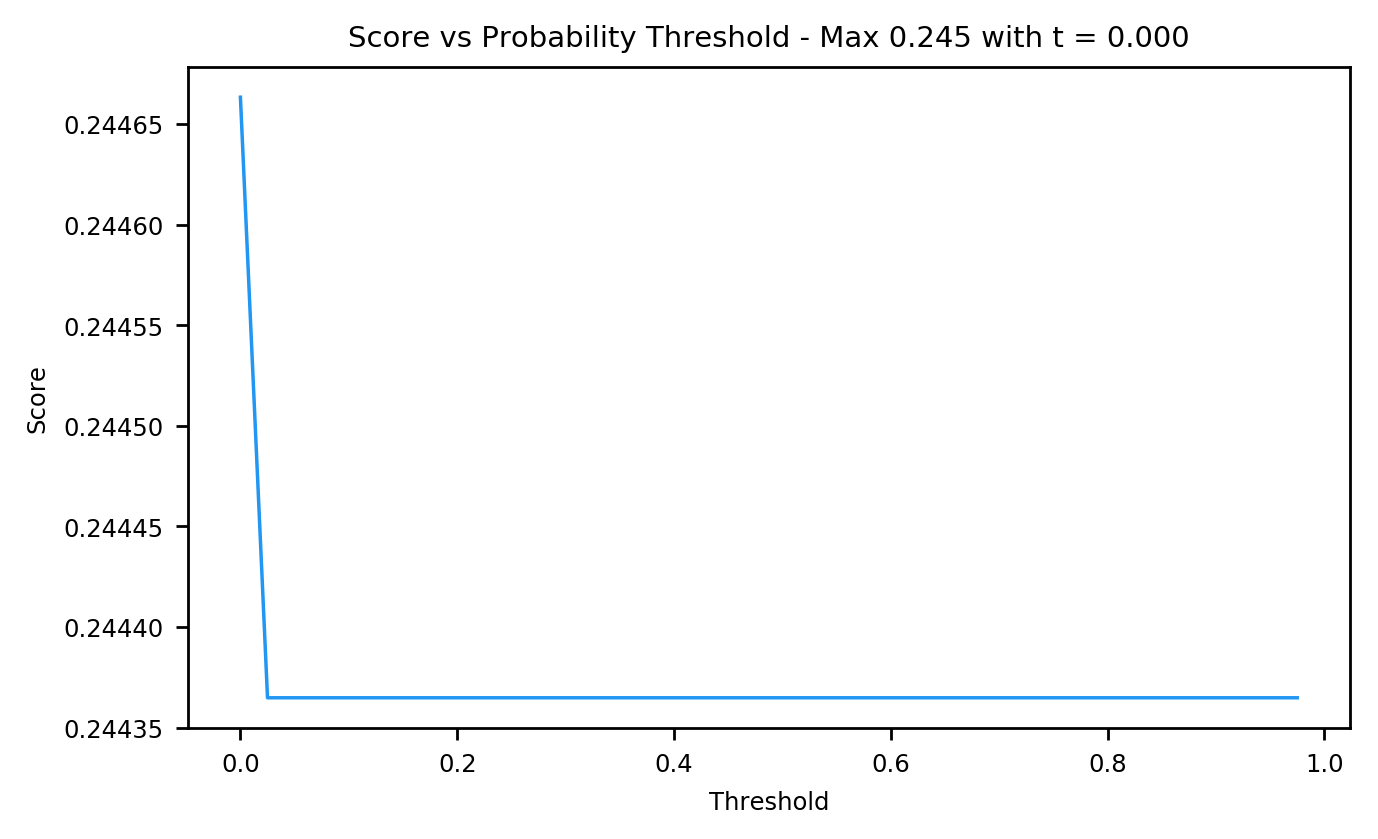

In [11]:
score_plot_genres(model, pca_x_test.as_matrix(), pca_y_test)

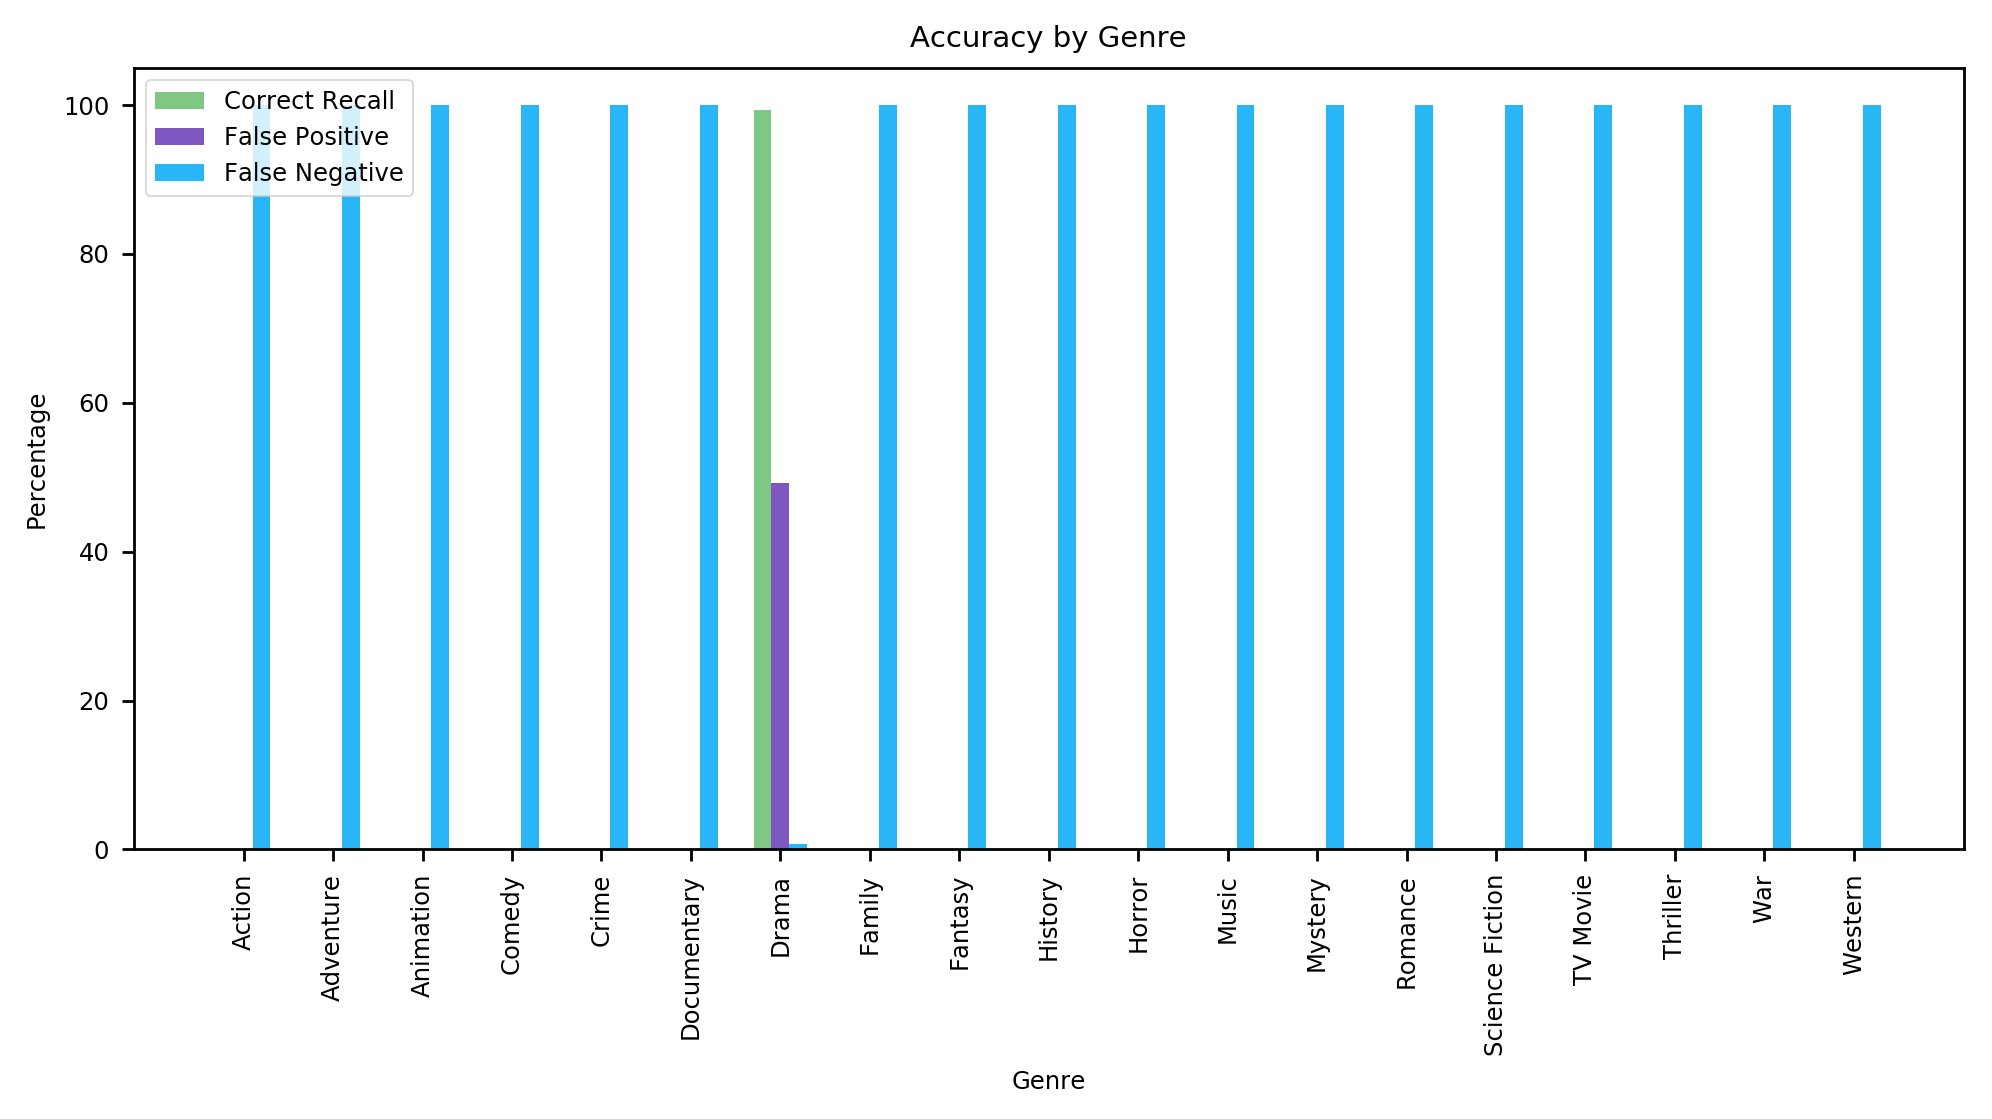

In [12]:
plot_genre_accuracy(model, pca_x_test.as_matrix(), pca_y_test, 0)

### Metadata + Poster PCAs

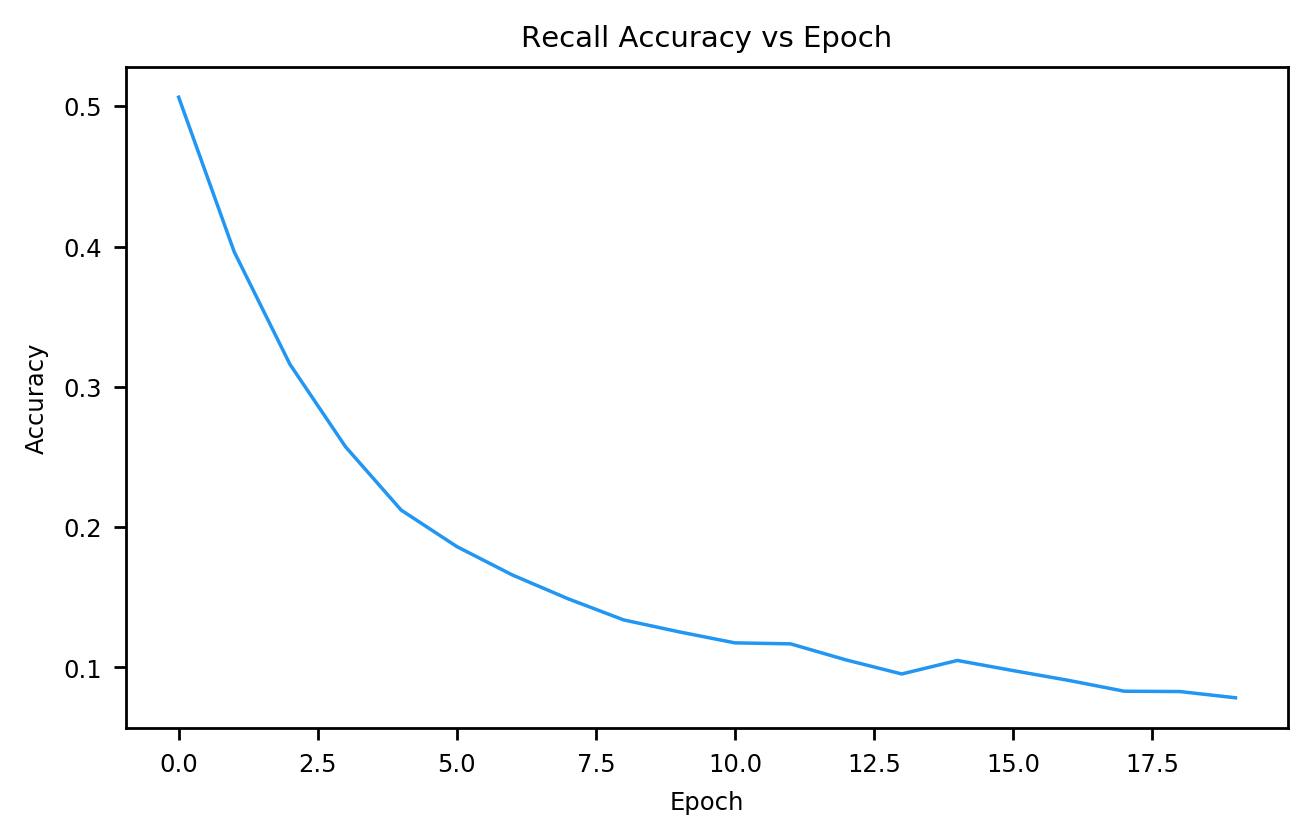

In [13]:
model, history = fit_seq_model(both_x_train.as_matrix(), both_y_train, both_x_test.as_matrix(), both_y_test)
history_plot(history)

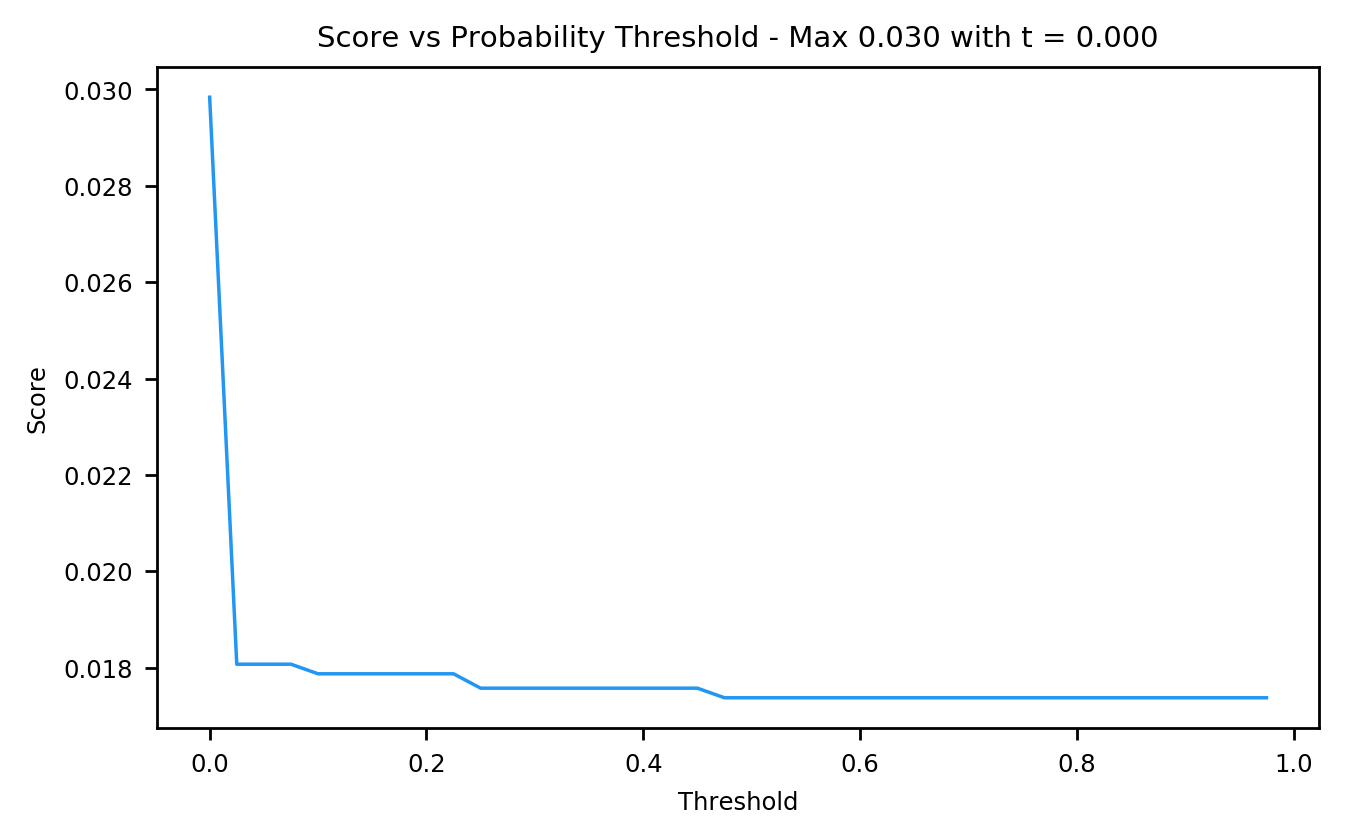

In [14]:
score_plot_genres(model, both_x_test.as_matrix(), both_y_test)

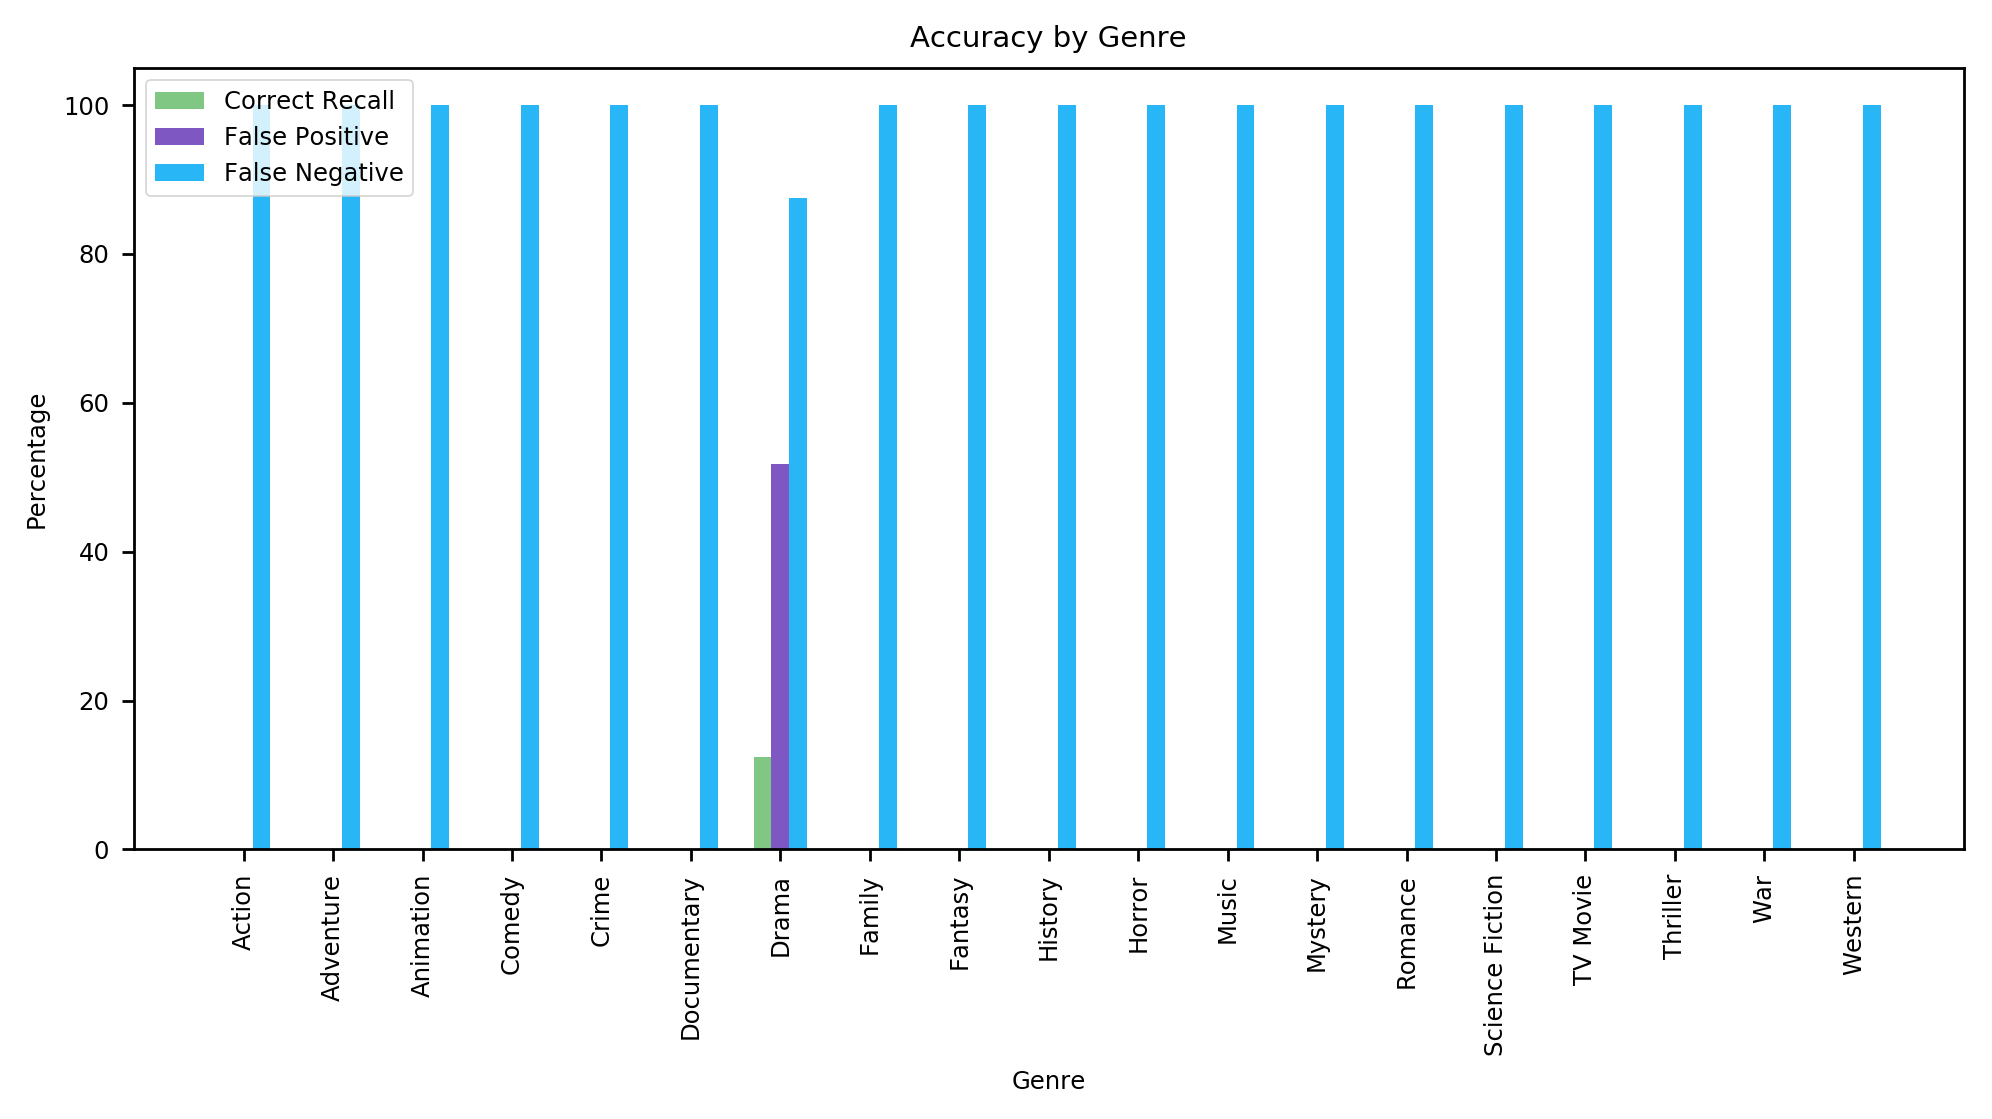

In [15]:
plot_genre_accuracy(model, both_x_test.as_matrix(), both_y_test, 0)